In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Obtener el número de núcleos lógicos a usar
nucleos = max(1, os.cpu_count() - 1)
print(f"Número de núcleos a usar: {nucleos}")

Número de núcleos a usar: 19


In [ ]:
# Cargar los datos
df = pd.read_csv('../data/BasePFLD.csv', index_col=0).dropna() / 100

# Identificar columnas numéricas
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

display(df)

,SegmentR,PEPR,AgeR,TimeRelationR,IncomeSourceR,ActivityR,NationalityR,CommonAddR,ProductTR,SubproductR,...,SumReR,RSR,AAR,SendingNumR,ReceivingNumR,StateOpeR,StateResR,MunOpeR,MunResR,CountryR
0,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.65,0.65,0.7,0.80,0.80,0.9,0.8,1.00,0.90,1.0
1,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.85,0.85,0.7,0.80,0.80,0.9,0.8,1.00,0.90,1.0
2,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.85,0.65,0.9,0.80,0.80,0.9,0.8,1.00,0.90,1.0
3,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.85,0.85,0.9,0.80,0.80,0.9,0.8,1.00,0.90,1.0
4,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.65,0.85,0.7,0.80,0.80,0.9,0.8,1.00,0.90,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.05,0.1,0.20,0.20,0.2,0.2,0.15,0.05,0.1
26747,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.25,0.1,0.20,0.05,0.3,0.1,0.15,0.05,0.1
26748,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.25,0.25,0.3,0.05,0.05,0.2,0.2,0.15,0.05,0.1
26749,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.05,0.25,0.1,0.05,0.05,0.3,0.2,0.15,0.05,0.1


In [5]:
# Función para calcular métricas de agrupamiento
def calcular_metricas(df, clustering_func, *params):
    """Calcula métricas de agrupamiento para un algoritmo dado.

    Args:
        df (pd.DataFrame): Conjunto de datos por agrupar.
        clustering_func (callable): Función crea el modelo de agrupamiento.
        *params: Parámetros a pasar a la función de agrupamiento.
    
    Returns:
        tuple: Coeficiente de silueta e índice de Davies-Bouldin (o None si no hay grupos válidos).
    """
    # Crear y ajustar el modelo de agrupamiento
    if clustering_func == DBSCAN:
        model = clustering_func(eps=params[0], min_samples=params[1])
    elif clustering_func == AgglomerativeClustering:
        model = clustering_func(n_clusters=params[0], linkage=params[1], metric=params[2])
    elif clustering_func == GaussianMixture:
        model = clustering_func(n_components=params[0], covariance_type=params[1])
    elif clustering_func == MeanShift:
        model = clustering_func(bandwidth=params[0])
    else:
        model = clustering_func(*params)
    
    # Ajustar el modelo y predecir las etiquetas
    labels = model.fit_predict(df)

    # Si hay más de un grupo, calcular las métricas
    if len(set(labels)) > 1:
        return (params, silhouette_score(df, labels), davies_bouldin_score(df, labels))
    return (params, None, None)

# Función para ejecutar evaluaciones de parámetros de agrupamiento
def evaluar_parametros(df, clustering_func, param_grid):
    """Evalúa diferentes configuraciones de parámetros para el agrupamiento."""
    return Parallel(n_jobs=nucleos)(
        delayed(calcular_metricas)(df, clustering_func, *params) for params in param_grid
    )

# Función para graficar métricas
def graficar_metricas(params, metric_1, metric_2, labels=("Parámetro", "Métrica 1", "Métrica 2")):
    """Grafica métricas de agrupamiento."""
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Gráfica de la primera métrica
    ax1.plot(params, metric_1, marker='o', color='darkred', label=labels[1])
    ax1.set_xlabel(labels[0], color='black')
    ax1.set_ylabel(labels[1], color='darkred')
    ax1.tick_params(axis='y', labelcolor='darkred')
    ax1.tick_params(axis='x', labelcolor='black')
    plt.xticks(rotation=45, ha='right')

    # Gráfica de la segunda métrica
    ax2 = ax1.twinx()
    ax2.plot(params, metric_2, marker='o', color='black', label=labels[2])
    ax2.set_ylabel(labels[2], color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'{labels[1]} e {labels[2]} por {labels[0]}', color='black')
    fig.tight_layout()
    display(plt)

def evaluar_agrupamiento(df, clustering_func, param_grid, metodo='silhouette'):
    """
    Evaluar un algoritmo de agrupamiento con diferentes configuraciones de parámetros y calcular métricas.

    Args:
        df (pd.DataFrame): Datos por agrupar.
        clustering_func (callable): Función del algoritmo de agrupamiento.
        param_grid (list): Lista de combinaciones de parámetros por probar.
        metodo (str): Método para el cálculo de la métrica, 'silhouette' o 'davies_bouldin'.
    
    Returns:
        pd.DataFrame: DataFrame con los resultados ordenados.
    """
    # Evaluar las combinaciones de parámetros
    resultados = evaluar_parametros(df, clustering_func, param_grid)
    
    # Crear un DataFrame con los resultados
    resultados_df = pd.DataFrame(resultados, columns=['Configuración', 'Coeficiente de silueta', 'Índice de Davies-Bouldin']).dropna(subset=['Coeficiente de silueta', 'Índice de Davies-Bouldin'])

    # Ordenar los resultados por métrica
    if metodo == 'silhouette':
        resultados_df = resultados_df.sort_values(by='Coeficiente de silueta', ascending=False)
    elif metodo == 'davies_bouldin':
        resultados_df = resultados_df.sort_values(by='Índice de Davies-Bouldin')
    
    # Graficar los resultados
    graficar_metricas(
        [str(param) for param in resultados_df['Configuración']], 
        resultados_df['Coeficiente de silueta'], 
        resultados_df['Índice de Davies-Bouldin'],
        labels=("Configuración", "Coeficiente de silueta", "Índice de Davies-Bouldin")
    )

    # Devolver un DataFrame con los resultados ordenados
    return resultados_df

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
4,"(6,)",0.591961,0.755662
3,"(5,)",0.585432,0.797201
2,"(4,)",0.582919,0.832228
5,"(7,)",0.581910,0.854543
1,"(3,)",0.580931,0.845769
0,"(2,)",0.571399,0.705877
7,"(9,)",0.569411,0.883584
6,"(8,)",0.501082,0.876827
8,"(10,)",0.278311,1.371654


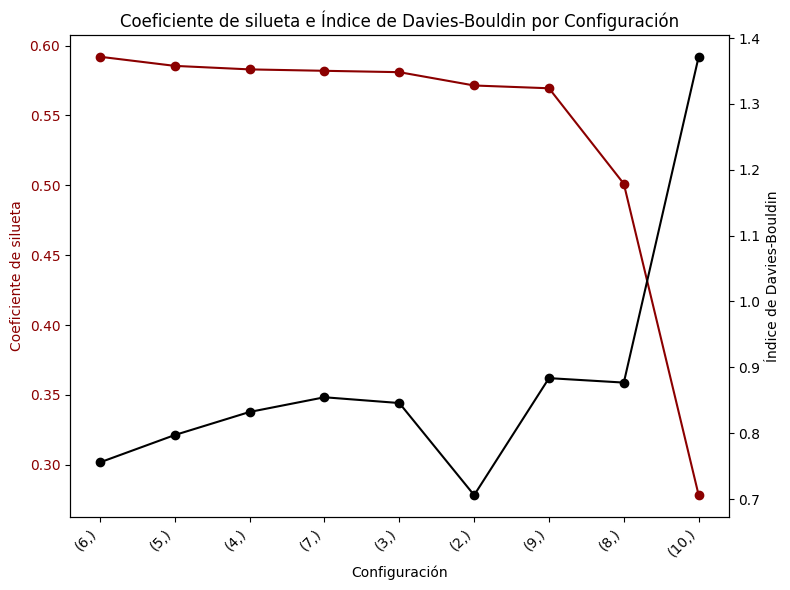

In [18]:
param_grid_kmeans = [(k,) for k in range(2, 11)]
resultados_kmeans = evaluar_agrupamiento(df, KMeans, param_grid_kmeans, metodo='silhouette')
display(resultados_kmeans)

/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
9,"(2.0, 5)",0.497843,1.003029
11,"(2.0, 15)",0.495567,1.170255
10,"(2.0, 10)",0.494126,1.064436
7,"(1.5, 10)",0.437756,1.260401
8,"(1.5, 15)",0.435021,1.402871
6,"(1.5, 5)",0.426601,1.407875
0,"(0.5, 5)",0.282344,1.377067
1,"(0.5, 10)",0.198373,1.256257
3,"(1.0, 5)",0.129911,1.915271
2,"(0.5, 15)",0.126335,1.173403


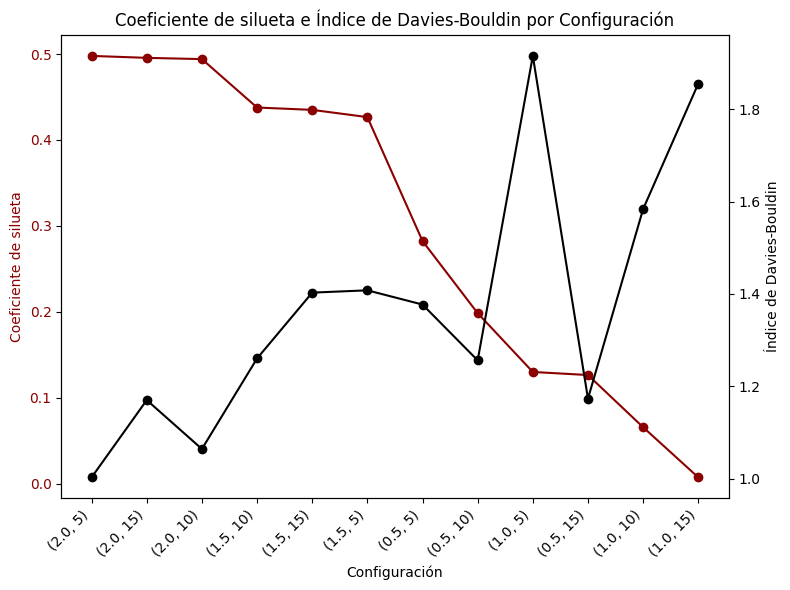

In [7]:
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 15]

param_grid_dbscan = [
    (eps, min_samples)
    for eps in eps_values for min_samples in min_samples_values
]

resultados_dbscan = evaluar_agrupamiento(df, DBSCAN, param_grid_dbscan, metodo='silhouette')
display(resultados_dbscan)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
30,"(5, ward, euclidean)",0.593105,0.732425
31,"(5, complete, euclidean)",0.585670,0.809868
34,"(5, average, euclidean)",0.584697,0.814374
22,"(4, complete, manhattan)",0.582919,0.832228
11,"(3, complete, euclidean)",0.580931,0.845769
41,"(6, complete, euclidean)",0.579978,0.903120
40,"(6, ward, euclidean)",0.578516,0.855613
12,"(3, complete, manhattan)",0.576202,0.880653
10,"(3, ward, euclidean)",0.575757,0.696265
20,"(4, ward, euclidean)",0.575006,0.870817


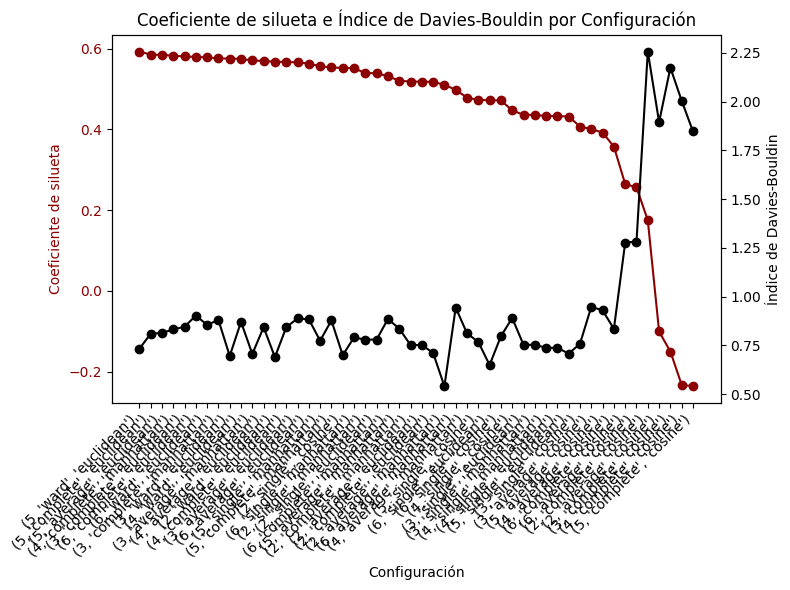

In [19]:
n_clusters_values = [2, 3, 4, 5, 6]
linkage_values = ['ward', 'complete', 'average', 'single']
affinity_values = ['euclidean', 'manhattan', 'cosine']

param_grid_agglomerative = [
    (n_clusters, linkage, affinity)
    for n_clusters in n_clusters_values
    for linkage in linkage_values
    for affinity in (affinity_values if linkage != 'ward' else ['euclidean'])
]

resultados_agglomerative = evaluar_agrupamiento(df, AgglomerativeClustering, param_grid_agglomerative, metodo='silhouette')
display(resultados_agglomerative)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
14,"(5, diag)",0.594083,0.788635
12,"(5, full)",0.593041,0.732736
13,"(5, tied)",0.592619,0.732767
10,"(4, diag)",0.582919,0.832228
6,"(3, diag)",0.580931,0.845769
5,"(3, tied)",0.580931,0.845769
4,"(3, full)",0.576202,0.880653
9,"(4, tied)",0.574643,0.880359
2,"(2, diag)",0.571631,0.704187
0,"(2, full)",0.571631,0.704187


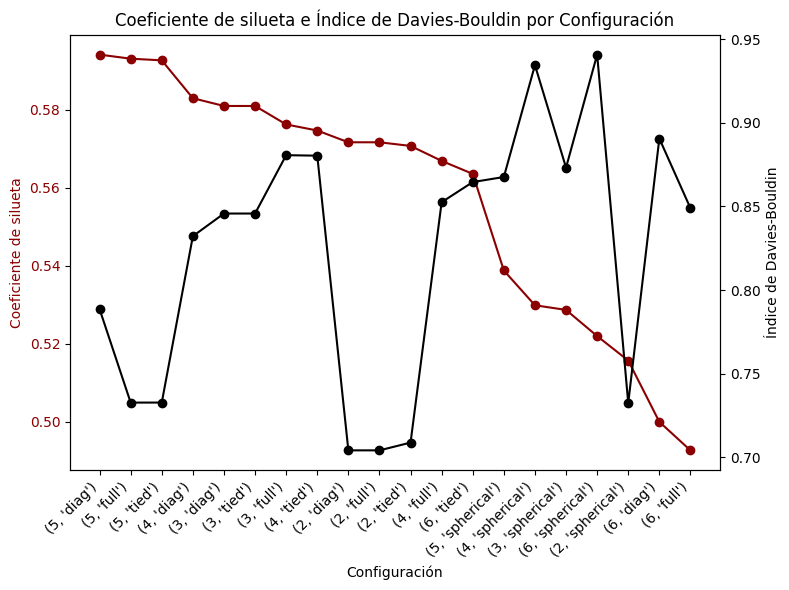

In [20]:
n_components_values = [2, 3, 4, 5, 6]
covariance_type_values = ['full', 'tied', 'diag', 'spherical']

param_grid_gaussian = [
    (n_components, covariance_type)
    for n_components in n_components_values
    for covariance_type in covariance_type_values
]

resultados_gaussian = evaluar_agrupamiento(df, GaussianMixture, param_grid_gaussian, metodo='silhouette')
display(resultados_gaussian)

<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

,Configuración,Coeficiente de silueta,Índice de Davies-Bouldin
0,"(None,)",0.582860,0.832206
2,"(1,)",0.581301,0.832200
1,"(0.5,)",0.462656,1.087798


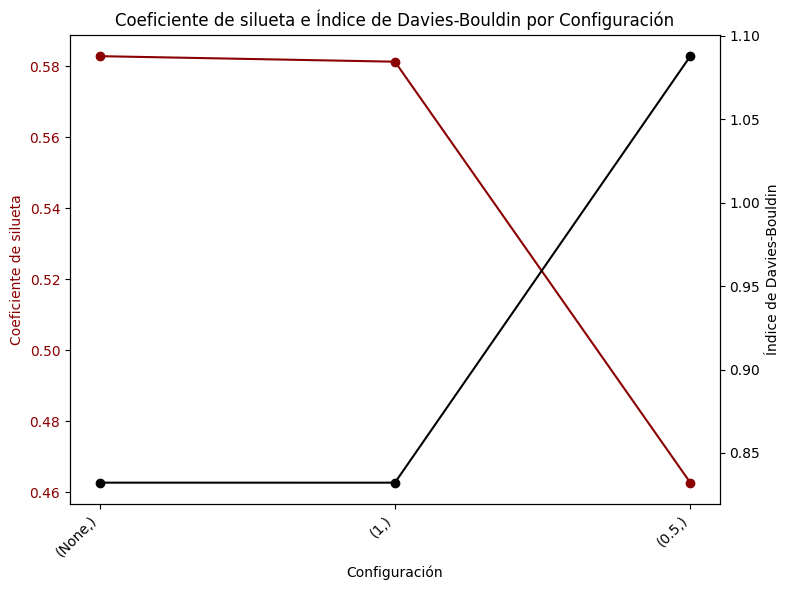

In [21]:
bandwidth_values = [(value,) for value in [None, 0.5, 1, 2, 3, 4]]
resultados_meanshift = evaluar_agrupamiento(df, MeanShift, bandwidth_values, metodo='silhouette')
display(resultados_meanshift)

In [60]:
# Configuración inicial del PCA
varianza_objetivo = 0.9
umbral = 0.7

# Realizar el análisis de componentes principales
pca_completo = PCA()
componentes_completas = pca_completo.fit_transform(df[columnas_numericas])

# Ajustar el PCA con la cantidad óptima de componentes
pca_reducido = PCA(n_components=varianza_objetivo, svd_solver='full')
componentes_reducidas = pca_reducido.fit_transform(df[columnas_numericas])

# Cálculo del indicador de anomalía
indicator = np.sum(
    np.dot(pca_df.iloc[:, :-pca_completo.n_components_], 
           np.square(pca_reducido.components_).T * pca_reducido.explained_variance_), 
    axis=1
) / pca_reducido.explained_variance_.sum()

# Crear DataFrame con todas las componentes principales y el indicador
pca_df = df.assign(
    **{f'PC{i+1}': componentes_completas[:, i] for i in range(componentes_completas.shape[1])},
    indicator=indicator,
    es_atipico=indicator > umbral
)

display(pca_df)

,SegmentR,PEPR,AgeR,TimeRelationR,IncomeSourceR,ActivityR,NationalityR,CommonAddR,ProductTR,SubproductR,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,indicator,es_atipico
0,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,-0.043244,0.027518,-0.044831,-0.008452,0.000137,-0.023271,-0.014129,-0.009865,0.900518,True
1,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,-0.004505,0.040315,0.059798,0.010093,0.000311,0.023259,-0.003213,0.004076,0.924981,True
2,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.008311,-0.017592,0.062453,0.017431,0.000208,0.024310,-0.003620,-0.001407,0.933631,True
3,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.009449,-0.053305,-0.087634,-0.028151,-0.000677,-0.011533,-0.002146,0.017647,0.932591,True
4,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.022154,-0.032984,-0.077064,-0.007096,-0.000409,-0.015490,-0.015487,-0.002604,0.909456,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.022331,0.015404,0.016129,0.004977,-0.000407,-0.008138,0.003832,0.002186,0.149122,False
26747,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,-0.045056,0.048706,-0.009165,0.007377,-0.000051,0.009664,-0.005828,0.007192,0.147657,False
26748,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,-0.016098,0.017268,0.004507,-0.011310,0.000413,-0.003415,-0.006152,0.011901,0.151728,False
26749,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.076840,0.004075,-0.017731,0.015521,0.000475,0.011172,0.005389,0.006228,0.146620,False


<module 'matplotlib.pyplot' from '/home/andres/Documentos/univ/maestria/4to/del-negociante/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

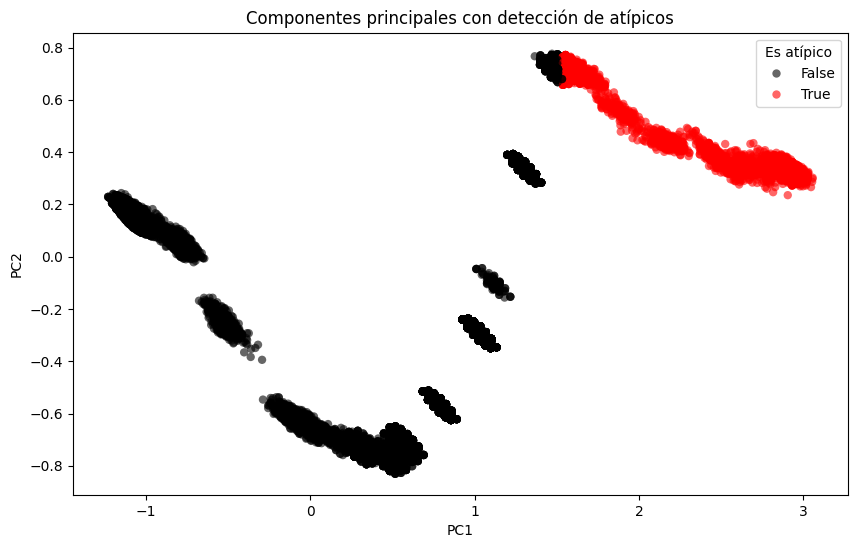

In [62]:
# Visualización de las componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=componentes_reducidas[:, 0],
    y=componentes_reducidas[:, 1],
    hue=pca_df['es_atipico'],
    palette=['black', 'red'],
    linewidth=0,
    alpha=0.6
)
plt.title('Componentes principales con detección de atípicos')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Es atípico')
display(plt)

In [63]:
# Conjunto de datos para agrupamiento
X = componentes_reducidas.astype(np.float32)

# K medias con 6 grupos
kmeans = KMeans(n_clusters=6, random_state=42)
pca_df['cluster_kmeans'] = kmeans.fit_predict(X)

# Agrupamiento aglomerativo con 5 grupos
agglo = AgglomerativeClustering(n_clusters=5, linkage='ward')
pca_df['cluster_agglo'] = agglo.fit_predict(X)

# Mezcla gaussiana con 5 componentes
gmm = GaussianMixture(
    n_components=5,
    covariance_type='diag',
    random_state=42,
    warm_start=True
)
pca_df['cluster_gmm'] = gmm.fit_predict(X)

display(pca_df)

,SegmentR,PEPR,AgeR,TimeRelationR,IncomeSourceR,ActivityR,NationalityR,CommonAddR,ProductTR,SubproductR,...,PC26,PC27,PC28,PC29,PC30,indicator,es_atipico,cluster_kmeans,cluster_agglo,cluster_gmm
0,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,-0.008452,0.000137,-0.023271,-0.014129,-0.009865,0.900518,True,2,2,2
1,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,0.75,...,0.010093,0.000311,0.023259,-0.003213,0.004076,0.924981,True,2,2,2
2,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,0.017431,0.000208,0.024310,-0.003620,-0.001407,0.933631,True,2,2,2
3,1.0,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,-0.028151,-0.000677,-0.011533,-0.002146,0.017647,0.932591,True,2,2,2
4,0.8,1.0,1.00,1.0,1.00,1.0,1.0,0.7,1.00,1.00,...,-0.007096,-0.000409,-0.015490,-0.015487,-0.002604,0.909456,True,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26746,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.004977,-0.000407,-0.008138,0.003832,0.002186,0.149122,False,1,1,1
26747,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.007377,-0.000051,0.009664,-0.005828,0.007192,0.147657,False,1,1,1
26748,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,-0.011310,0.000413,-0.003415,-0.006152,0.011901,0.151728,False,1,1,1
26749,0.2,0.1,0.33,0.2,0.25,0.2,0.1,0.1,0.25,0.10,...,0.015521,0.000475,0.011172,0.005389,0.006228,0.146620,False,1,1,1


In [65]:
# Procesamiento de grupos
def process_clusters(col_name):
    risk = pca_df.groupby(col_name)['indicator'].mean()
    mapping = {cluster: i for i, cluster in enumerate(risk.sort_values().index)}
    return pca_df[col_name].map(mapping), risk.sort_values()

# Calcular los riesgos promedio por grupo
pca_df['cluster_kmeans'], risk_kmeans = process_clusters('cluster_kmeans')
pca_df['cluster_agglo'], risk_agglo = process_clusters('cluster_agglo')
pca_df['cluster_gmm'], risk_gmm = process_clusters('cluster_gmm')

# Mostrar los resultados renombrados
print("Riesgo promedio por grupo (k medias):")
display(risk_kmeans)

print("\nRiesgo promedio por grupo (aglomerativo):")
display(risk_agglo)

print("\nRiesgo promedio por grupo (mezcla gaussiana):")
display(risk_gmm)

Riesgo promedio por grupo (k medias):


cluster_kmeans
0    0.155806
1    0.403105
2    0.560510
3    0.687726
4    0.834741
5    0.915724
Name: indicator, dtype: float64


Riesgo promedio por grupo (aglomerativo):


cluster_agglo
0    0.156221
1    0.422974
2    0.578266
3    0.699607
4    0.906376
Name: indicator, dtype: float64


Riesgo promedio por grupo (mezcla gaussiana):


cluster_gmm
0    0.149895
1    0.353849
2    0.560510
3    0.702731
4    0.908121
Name: indicator, dtype: float64

In [66]:
# Cálculo de métricas
num_transacciones = len(df)
num_atipicas = pca_df['es_atipico'].sum()
stats = {
    'transacciones_totales': num_transacciones,
    'transacciones_atipicas': num_atipicas,
    'porcentaje_atipicas': (num_atipicas / num_transacciones) * 100,
    'min_indicador': indicator.min(),
    'max_indicador': indicator.max(),
    'media_indicador': indicator.mean()
}

# Resultados
print(f"""
Métricas clave:
- Transacciones totales: {stats['transacciones_totales']}
- Transacciones atípicas: {stats['transacciones_atipicas']} ({stats['porcentaje_atipicas']:.2f}%)
- Indicador mínimo: {stats['min_indicador']:.4f}
- Indicador máximo: {stats['max_indicador']:.4f}
- Media del indicador: {stats['media_indicador']:.4f}
""")


Métricas clave:
- Transacciones totales: 26751
- Transacciones atípicas: 3592 (13.43%)
- Indicador mínimo: 0.1296
- Indicador máximo: 0.9424
- Media del indicador: 0.3629



In [67]:
# Exportar resultados
pca_df.to_csv('../data/resultado_pca.csv', index=False, float_format='%.4f')
print("Resultados exportados a 'resultado_pca.csv'")

Resultados exportados a 'resultado_pca.csv'
